In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import mixture, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # similar to Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix, classification_report, accuracy_score 
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.covariance import empirical_covariance

# import scipy
import csv # for excel too 
import json 
import random
import numpy as np
import itertools 
import sys
import os
import matplotlib as mpl
import nltk
# nltk.download("stopwords")
# nltk.download("averaged_perceptron_tagger")

from nltk.stem.porter import *
# from scipy import linalg

# import word embeddings models 
from transformers import BertTokenizer, BertModel
import torch

# Remove all the un-necessary warnings
# import warnings
# warnings.filterwarnings('ignore')
path = 'CONAN-master/Multitarget-CONAN/'
file = 'Multitarget-CONAN.json'
file_p = path + file

davidson_path = 'hate-speech-and-offensive-language-master/data/'
davidson_f = 'labeled_data.csv' 
davidson_p = davidson_path + davidson_f

output_path = 'classification_reports/'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trice\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\trice\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [93]:
# opens json file and loads json as dictionary 
# on Windows encoding is utf8 so make sure to specify 
with open(file_p, "r", encoding="utf8") as f:
    multi_target = json.load(f)

# print(davidson_p)
davidson_full_data = pd.read_csv(davidson_p)

multi_target = pd.DataFrame(multi_target)
# print(multi_target)

davidson_full_df = pd.DataFrame(davidson_full_data)
print(davidson_full_df)

# for ind in multi_target: 
# #     print(ind)
#     for head in multi_target[ind]:
# #         print(" " + head)
#         # print out 4 types (Hate speech, counter narrative, target person, version) and string value 
# #         print("  " + multi_target[ind][head])
#         multi_target[ind][head]

# Turns json file/python dict format into pandas dataframe 
mt_df = pd.DataFrame(multi_target)
# print(mt_df)

# collects hate speech into dataframe and series 
hs_orig = mt_df.iloc[0, :] 
# print(hs_orig)

# collects counter narrative into dataframe and series 
# cn_orig = mt_df.iloc[1, :] 
# print(cn_orig)

# collects target minority into dataframe and series 
min_tar_orig = mt_df.iloc[2, :] # pd.DataFrame(mt_df.iloc[2, :], columns = ["TARGET"])
# print(min_tar_orig)

labels = np.unique(min_tar_orig)
print(labels)

# add label for not hate speech 
labels = np.append(labels, 'none') 
print(labels)

# collects version of dataset into dataframe and series 
# vers_orig = mt_df.iloc[3, :] 
# print(vers_orig)

f.close()

       Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0               0      3            0                   0        3      2   
1               1      3            0                   3        0      1   
2               2      3            0                   3        0      1   
3               3      3            0                   2        1      1   
4               4      6            0                   6        0      1   
...           ...    ...          ...                 ...      ...    ...   
24778       25291      3            0                   2        1      1   
24779       25292      3            0                   1        2      2   
24780       25294      3            0                   3        0      1   
24781       25295      6            0                   6        0      1   
24782       25296      3            0                   0        3      2   

                                                   tweet  
0      !!! RT @m

In [114]:
def make_heatmap(conf_m, labels, save = True, out_file = ''): 
    size = len(conf_m)
    matrix = np.zeros((size, size))
    for i in range(0, size):
        matrix[i,:] = conf_m[i,:]/float(conf_m[i,:].sum())
    # labels = ['Hate','Offensive','Neither']
    conf_df = pd.DataFrame(matrix, index=labels, columns = labels)
    
    plt.figure(figsize=(size * 1.5, size * 1.25))
    sns.heatmap(conf_df, annot = True, annot_kws = {"size": 12},
                    cmap='gist_gray_r', cbar = False, square = True, fmt = '.2f')
    plt.ylabel(r'True categories', fontsize=14)
    plt.xlabel(r'Predicted categories', fontsize=14)
    plt.tick_params(labelsize = 12)

    if save:
        plt.savefig(out_file) # '.pdf')

In [121]:
stopwords = stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    print(parsed_text)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    print(parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    print(parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]+", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]+", tweet.lower())).strip()
    return tweet.split()

In [105]:
#Get POS tags for tweets and save as a string
tweets = davidson_full_df.tweet
# tweet_tags = []
# for t in tweets:
#     tokens = basic_tokenize(preprocess(t))
#     tags = nltk.pos_tag(tokens)
#     tag_list = [x[1] for x in tags]
#     tag_str = " ".join(tag_list)
#     tweet_tags.append(tag_str)

davidson_class = davidson_full_df.iloc[:, -2] 
processed_class = davidson_class[davidson_class != 1] # excludes offensive speech 
processed_tweets = davidson_full_df[davidson_full_df['class'] != 1]
processed_tweets = processed_tweets[processed_tweets['class'] == 2]

processed_tweets = processed_tweets.iloc[:, -1]
print(processed_tweets)

0        !!! RT @mayasolovely: As a woman you shouldn't...
40         " momma said no pussy cats inside my doghouse "
63       "@Addicted2Guys: -SimplyAddictedToGuys http://...
66       "@AllAboutManFeet: http://t.co/3gzUpfuMev" woo...
67       "@Allyhaaaaa: Lemmie eat a Oreo &amp; do these...
                               ...                        
24736    yaya ho.. cute avi tho RT @ViVaLa_Ari I had no...
24737    yea so about @N_tel 's new friend.. all my fri...
24767    you know what they say, the early bird gets th...
24779    you've gone and broke the wrong heart baby, an...
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 4163, dtype: object


In [138]:
combined_hate_df = hs_orig.append(processed_tweets)
print(combined_hate_df)

ind_combined_hate_df = combined_hate_df.reset_index(drop = True) 
print(ind_combined_hate_df) 

# ind_combined_hate_df.to_excel('Combined_dataset.xlsx', index = False, encoding='utf8')
ind_combined_hate_df.to_csv('Combined_dataset.csv', sep = ",", index = False, encoding='utf8')

0        Maybe the UN could talk to those asian and afr...
1        ‘Juice (Jews) are worse that nukes.’ Caption t...
2        Foreigners on UK benefits leaps 41% in 5 years...
3        Jews cannot be patriots, since their allegianc...
4        Israel, Zionism and Jewish Supremacist control...
                               ...                        
24736    yaya ho.. cute avi tho RT @ViVaLa_Ari I had no...
24737    yea so about @N_tel 's new friend.. all my fri...
24767    you know what they say, the early bird gets th...
24779    you've gone and broke the wrong heart baby, an...
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Length: 9166, dtype: object
0       Maybe the UN could talk to those asian and afr...
1       ‘Juice (Jews) are worse that nukes.’ Caption t...
2       Foreigners on UK benefits leaps 41% in 5 years...
3       Jews cannot be patriots, since their allegianc...
4       Israel, Zionism and Jewish Supremacist control...
                              ...

In [108]:
# print(min_tar)
# print(processed_class) # class 0 is hate speech and 2 is neither 

# processed_class = processed_class[processed_class == 2]
# processed_class.replace({2 : 8}, inplace=True)
print(processed_class) # class 0 is hate speech and 2 is neither 

combined_tar_df = min_tar.append(processed_class)
display(combined_tar_df)

0        8
40       8
63       8
66       8
67       8
        ..
24736    8
24737    8
24767    8
24779    8
24782    8
Name: class, Length: 4163, dtype: int64


0        7
1        1
2        3
3        1
4        1
        ..
24736    8
24737    8
24767    8
24779    8
24782    8
Length: 9166, dtype: int64

In [83]:
# print(tokens)
# print(tweet_tags)
# print(tag_list)
# print(tags)

In [84]:
# transpose to make value feature and number of values x axis (columns) 
mt_df_T = mt_df.T 
mt_df_T.head()
# mt_df_T[mt_df_T.isnull().any(axis=1)] # remove null values from dataframe - unnecessary for this data 


,HATE_SPEECH,COUNTER_NARRATIVE,TARGET,VERSION
0,Maybe the UN could talk to those asian and afr...,"You're right, ocean pollution is one of the ma...",other,V1
1,‘Juice (Jews) are worse that nukes.’ Caption t...,You'd rather be nuked then?,JEWS,V1
2,Foreigners on UK benefits leaps 41% in 5 years...,You seem to be worried about government expend...,MIGRANTS,V1
3,"Jews cannot be patriots, since their allegianc...",You can have parents and grandparents born els...,JEWS,V1
4,"Israel, Zionism and Jewish Supremacist control...",Wouldn't you say its colonialism from many dif...,JEWS,V1


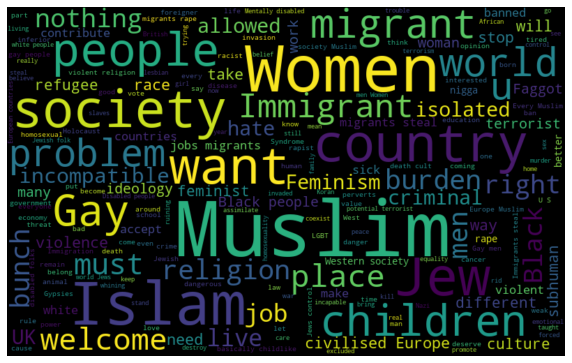

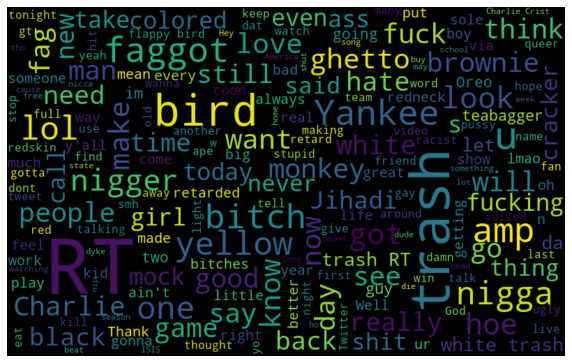

In [90]:
# visualizing which of the word is most commonly used in the twitter dataset
from wordcloud import WordCloud

# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in mt_df_T['HATE_SPEECH'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

all_words2 = ' '.join([preprocess(text) for text in processed_tweets])
wordcloud2 = WordCloud(width = 800, height = 500, random_state = 0, max_font_size = 110).generate(all_words2)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis('off')
plt.show()

In [109]:
# min_tar = min_tar_orig.replace(labels, range(len(labels)))
# print(min_tar)

#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# max and min are cutoffs for document frequency 
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                                   max_df = 0.75, min_df=5, 
                                   max_features=10000)

# TF-IDF feature matrix
docs = tfidf_vectorizer.fit_transform(combined_hate_df)
display(docs)

<9166x5733 sparse matrix of type '<class 'numpy.float64'>'
	with 148204 stored elements in Compressed Sparse Row format>

              precision    recall  f1-score   support

           0       1.00      0.76      0.87        55
           1       0.98      0.92      0.95       128
           2       0.97      0.87      0.92       112
           3       0.94      0.97      0.95       186
           4       0.95      0.96      0.96       273
           5       0.97      0.81      0.88        79
           6       0.97      0.97      0.97       117
           7       1.00      0.42      0.60        59
           8       0.92      1.00      0.96       825

    accuracy                           0.94      1834
   macro avg       0.97      0.85      0.89      1834
weighted avg       0.94      0.94      0.94      1834

Logistic Regression Train accuracy 96.549%
Logistic Regression Test accuracy 94.111%
Confusion matrix: 
[[ 42   0   2   0   0   1   1   0   9]
 [  0 118   0   0   0   0   0   0  10]
 [  0   0  97   0   1   1   3   0  10]
 [  0   0   0 180   2   0   0   0   4]
 [  0   0   0   4 262   0   0   0  

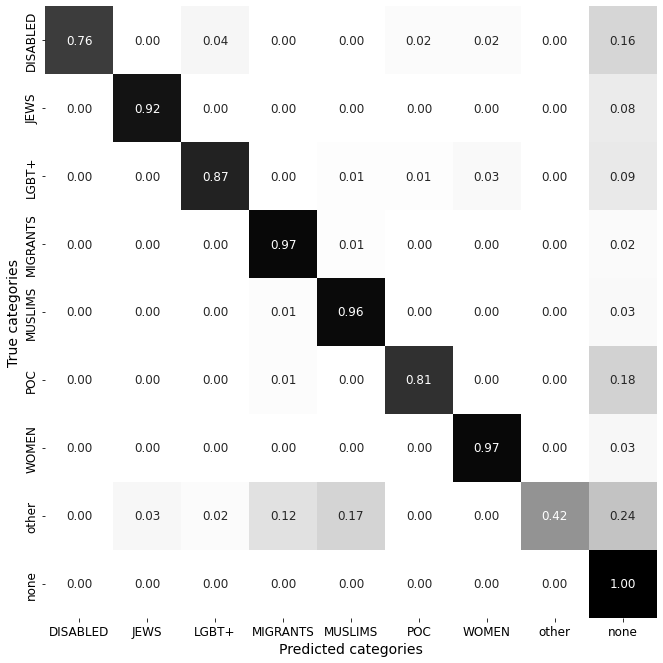

In [125]:
X = docs
y = combined_tar_df
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
classifiers = ["LogisticRegression", "RandomForest", "DecisionTrees", "XGBoost"]

y_preds = model.predict(X_test)

report = classification_report(y_test, y_preds)
print(report)
acc = accuracy_score(y_test, y_preds)
mod_train = model.score(X_train, y_train) 

print('Logistic Regression Train accuracy {:.3f}%'.format(mod_train * 100)) 
print('Logistic Regression Test accuracy {:.3f}%'.format(acc * 100)) 

print('Confusion matrix: ')
conf_m = confusion_matrix(y_test, y_preds)
print(conf_m)
make_heatmap(conf_m, labels, save = False, out_file = output_path + classifiers[0] + '_combined.pdf')

# clsf_report = pd.DataFrame(classification_report(y_test, y_preds, output_dict = True)).transpose()
# clsf_report.to_csv(output_path + classifiers[0] + '_combined' + '.csv', index= True)

In [7]:
print(pd.Series(y_test))
print(pd.Series(y_preds))

414     3
1815    0
642     7
1056    2
4507    0
       ..
1623    3
2005    1
4174    3
3467    7
3475    6
Name: TARGET, Length: 1001, dtype: int64
0       3
1       0
2       6
3       2
4       0
       ..
996     3
997     1
998     3
999     7
1000    6
Length: 1001, dtype: int64


              precision    recall  f1-score   support

           0       1.00      0.76      0.87        55
           1       0.99      0.95      0.97       128
           2       0.96      0.86      0.91       112
           3       0.93      0.97      0.95       186
           4       0.96      0.97      0.97       273
           5       0.94      0.77      0.85        79
           6       0.94      0.96      0.95       117
           7       1.00      0.59      0.74        59
           8       0.94      1.00      0.96       825

    accuracy                           0.95      1834
   macro avg       0.96      0.87      0.91      1834
weighted avg       0.95      0.95      0.94      1834

Random Forest Train accuracy 96.549%
Random Forest Test accuracy 94.656%
Confusion matrix: 
[[ 42   0   3   0   1   1   0   0   8]
 [  0 122   0   1   0   0   0   0   5]
 [  0   0  96   1   0   1   4   0  10]
 [  0   0   0 180   2   0   0   0   4]
 [  0   0   0   3 266   0   0   0   4]
 [  0   

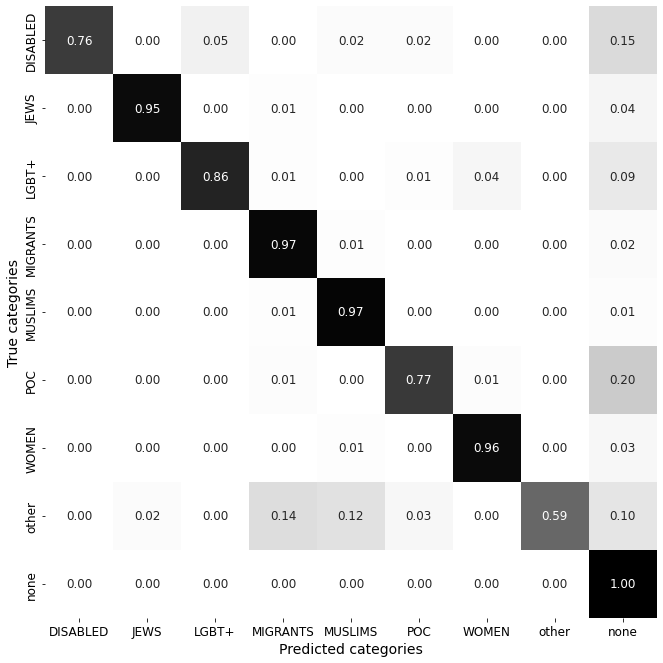

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test)
report = classification_report(y_test, y_preds)
acc1 = accuracy_score(y_test, y_preds)
mod_train1 = model.score(X_train, y_train) 

print(report)

print('Random Forest Train accuracy {:.3f}%'.format(mod_train1 * 100)) 
print('Random Forest Test accuracy {:.3f}%'.format(acc1 * 100)) 

print('Confusion matrix: ')
conf_m = confusion_matrix(y_test, y_preds)
print(conf_m)
make_heatmap(conf_m, labels, save = False, out_file = output_path + classifiers[0] + '_combined.pdf')


              precision    recall  f1-score   support

           0       0.86      0.80      0.83        55
           1       0.83      0.75      0.79       128
           2       0.87      0.81      0.84       112
           3       0.88      0.82      0.85       186
           4       0.78      0.75      0.77       273
           5       0.71      0.57      0.63        79
           6       0.94      0.80      0.87       117
           7       0.41      0.66      0.51        59
           8       0.93      0.98      0.95       825

    accuracy                           0.86      1834
   macro avg       0.80      0.77      0.78      1834
weighted avg       0.86      0.86      0.86      1834

Naive Bayes Train accuracy 96.549%
Naive Bayes Test accuracy 85.769%
Confusion matrix: 
[[ 44   0   4   0   2   0   0   0   5]
 [  0  96   2   5   7   2   0   7   9]
 [  1   4  91   0   8   2   2   0   4]
 [  0   0   2 152  13   2   0  14   3]
 [  0   3   0   6 206   5   0  32  21]
 [  0   5   

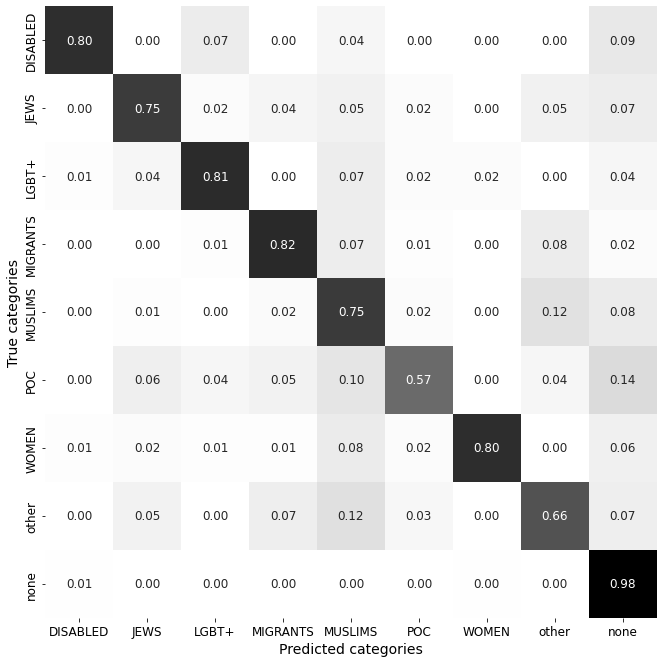

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), 
                                                    y, random_state=42, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train, y_train)
y_preds = nb.predict(X_test)
report = classification_report(y_test, y_preds)
acc2 = accuracy_score(y_test, y_preds)
mod_train2 = model.score(X_train, y_train) 

print(report)

print('Naive Bayes Train accuracy {:.3f}%'.format(mod_train2 * 100)) 
print('Naive Bayes Test accuracy {:.3f}%'.format(acc2 * 100)) 

print('Confusion matrix: ')
conf_m = confusion_matrix(y_test, y_preds)
print(conf_m)
make_heatmap(conf_m, labels, save = False, out_file = output_path + classifiers[0] + '_combined.pdf')


              precision    recall  f1-score   support

           0       0.78      0.69      0.73        55
           1       0.97      0.97      0.97       128
           2       0.87      0.83      0.85       112
           3       0.86      0.95      0.91       186
           4       0.96      0.95      0.95       273
           5       0.91      0.80      0.85        79
           6       0.92      0.92      0.92       117
           7       0.64      0.61      0.63        59
           8       0.95      0.96      0.95       825

    accuracy                           0.92      1834
   macro avg       0.87      0.85      0.86      1834
weighted avg       0.92      0.92      0.92      1834

Decision Trees Train accuracy 96.549%
Decision Trees Test accuracy 91.876%
Confusion matrix: 
[[ 38   0   1   1   0   0   0   4  11]
 [  0 124   0   0   0   0   0   1   3]
 [  2   1  93   5   0   1   5   0   5]
 [  1   0   2 177   1   0   0   1   4]
 [  0   0   0   3 258   0   1   9   2]
 [  1 

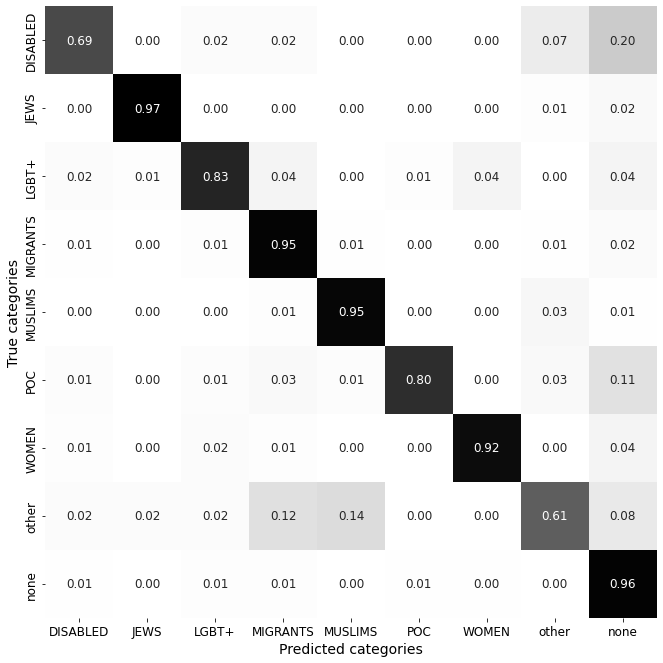

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)

y_preds = dt.predict(X_test)
report = classification_report(y_test, y_preds)
acc3 = accuracy_score(y_test, y_preds)
mod_train3 = model.score(X_train, y_train) 

print(report)

print('Decision Trees Train accuracy {:.3f}%'.format(mod_train3 * 100)) 
print('Decision Trees Test accuracy {:.3f}%'.format(acc3 * 100)) 

print('Confusion matrix: ')
conf_m = confusion_matrix(y_test, y_preds)
print(conf_m)
make_heatmap(conf_m, labels, save = False, out_file = output_path + classifiers[0] + '_combined.pdf')


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   8.1s
[CV] END .....................................C=0.1, gamma=1; total time=   7.9s
[CV] END .....................................C=0.1, gamma=1; total time=   8.0s
[CV] END .....................................C=0.1, gamma=1; total time=   8.0s
[CV] END .....................................C=0.1, gamma=1; total time=   7.9s
[CV] END ...................................C=0.1, gamma=0.1; total time=   6.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   7.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   6.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   6.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=   7.3s
[CV] END ..................................C=0.1, gamma=0.01; total time=   6.7s
[CV] END ..................................C=0.1

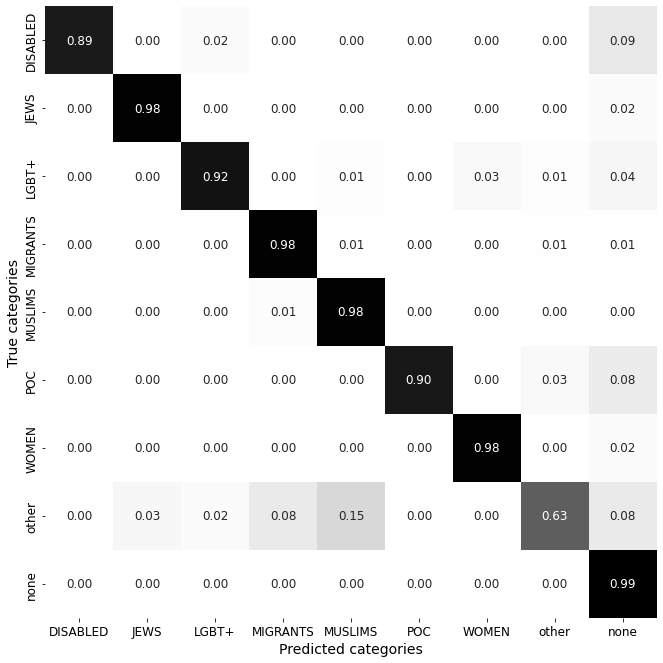

In [128]:
# considers params and gamma heavily with gaussian

# model selection and hyperparamter tuning step 
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1 , 0.1, 0.01, 0.001]} 
svm_grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)

svm_grid.fit(X_train, y_train)

y_preds = svm_grid.predict(X_test)
report = classification_report(y_test, y_preds)
acc4 = accuracy_score(y_test, y_preds)
mod_train4 = model.score(X_train, y_train) 

print(report)

print('SVM Train accuracy {:.3f}%'.format(mod_train4 * 100)) 
print('SVM Test accuracy {:.3f}%'.format(acc4 * 100)) 

print('Confusion matrix: ')
conf_m = confusion_matrix(y_test, y_preds)
print(conf_m)
make_heatmap(conf_m, labels, save = False, out_file = output_path + classifiers[0] + '_combined.pdf')


C:\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        55
           1       0.97      0.98      0.97       128
           2       0.99      0.94      0.96       112
           3       0.97      0.99      0.98       186
           4       0.96      0.99      0.97       273
           5       0.97      0.90      0.93        79
           6       0.97      0.98      0.98       117
           7       0.93      0.64      0.76        59
           8       0.97      0.99      0.98       825

    accuracy                           0.97      1834
   macro avg       0.97      0.92      0.94      1834
weighted avg       0.97      0.97      

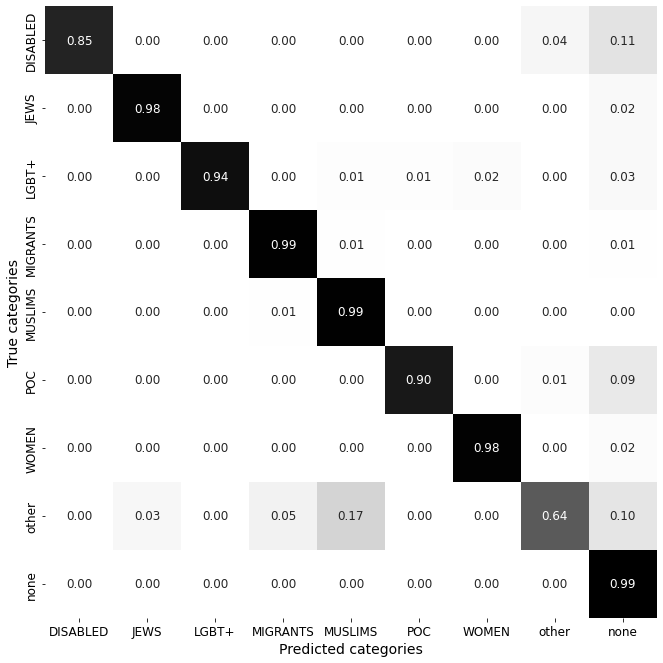

In [130]:
xg = XGBClassifier(random_state = 0)
xg.fit(X_train, y_train)

y_preds = xg.predict(X_test)
report = classification_report(y_test, y_preds)
acc4 = accuracy_score(y_test, y_preds)
mod_train4 = model.score(X_train, y_train) 

print(report)

print('XG Trees Train accuracy {:.3f}%'.format(mod_train3 * 100)) 
print('XG Trees Test accuracy {:.3f}%'.format(acc3 * 100)) 

print('Confusion matrix: ')
conf_m = confusion_matrix(y_test, y_preds)
print(conf_m)
make_heatmap(conf_m, labels, save = False, out_file = output_path + classifiers[0] + '_combined.pdf')

In [120]:
# LSTM and CNN *** sharfard paper 
lstm = torch.nn.LSTM(X) # 10, 20, 2)
# inputs = torch.randn(5, 3, 10)
# h0 = torch.randn(2, 3, 20)
# c0 = torch.randn(2, 3, 20)
output, (hn, cn) = lstm(inputs, (h0, c0))

print("Output:")
print(output)
print()
print("hn:")
print(hn)
print()
print("cn:")
print(cn)

Output:
tensor([[[ 0.1320, -0.1621, -0.3100, -0.1136, -0.3245, -0.3054,  0.1341,
          -0.0264,  0.3513, -0.0011,  0.1138, -0.2330, -0.1603,  0.0683,
          -0.0063,  0.1411, -0.0968, -0.0457,  0.3358, -0.1455],
         [ 0.0014,  0.3106,  0.1382,  0.1185, -0.6976, -0.1909,  0.0579,
           0.2505,  0.0958,  0.2306,  0.3701,  0.0493,  0.3401,  0.0155,
           0.1035, -0.3137, -0.0766,  0.1236, -0.0233, -0.0324],
         [-0.1575, -0.2405,  0.5352, -0.3077, -0.4568, -0.0830, -0.1255,
           0.4290,  0.2272, -0.3143, -0.5924,  0.2815,  0.6225,  0.4964,
           0.0807, -0.1017,  0.1540, -0.3155,  0.1077,  0.2016]],

        [[ 0.0507, -0.0794, -0.0249, -0.0036, -0.2226, -0.1870,  0.0762,
           0.0355,  0.2235, -0.0482,  0.0833, -0.0217, -0.0757,  0.0098,
           0.1203,  0.0126, -0.0750, -0.0233,  0.1322, -0.0273],
         [-0.0387,  0.2134,  0.0999,  0.0919, -0.3387, -0.1048,  0.0132,
           0.1521,  0.0836,  0.1549,  0.2152,  0.0339,  0.0439, -0.0360,


In [85]:
# display(y)
# display(pd.Series(y_preds))